# Experiments for the Bachelor's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed for the Bachelor's Program in Business Informatics of the University of Mannheim

## 1. Imports and Graph Loading

In [1]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

G = nx.read_graphml("CourseSkillGraph_Bachelor.graphml")

hier


## 3. Experiments
### 3.1 Prerequisite Relationships

In [2]:
# Count amount of courses with prerequisites

courses_with_simple_prerequisite = []
courses_with_complex_prerequisite = []
courses_with_simple_exclusive_prerequiste = []
courses_with_complex_exclusive_prerequiste = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_complex_prerequisite:
                courses_with_complex_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_complex_exclusive_prerequiste:
                courses_with_complex_exclusive_prerequiste.append(node)

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_simple_prerequisite:
                courses_with_simple_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_simple_exclusive_prerequiste:
                courses_with_simple_exclusive_prerequiste.append(node)


print("Simple prerequisite relationships: " + str(courses_with_simple_prerequisite) + "\n")
print("Complex prerequisite relationships: " + str(courses_with_complex_prerequisite) + "\n")
print("Courses with simple exclusive prerequisite relationships: " + str(courses_with_simple_exclusive_prerequiste) + "\n")
print("Courses with complex exclusive prerequisite relationships: " + str(courses_with_complex_exclusive_prerequiste) + "\n")


print("Amount of courses with prerequisite: " + str(len(courses_with_simple_prerequisite) + len(courses_with_complex_prerequisite)))



Simple prerequisite relationships: ['CS 308 Softwaretechnik I Software Engineering I']

Complex prerequisite relationships: ['CS 306 Praktikum Software Engineering Software Engineering Practical']

Courses with simple exclusive prerequisite relationships: []

Courses with complex exclusive prerequisite relationships: []

Amount of courses with prerequisite: 2


In [3]:
#Count number of courses

course_amount = 0
for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        course_amount += 1

print("Amount of courses: " + str(course_amount) + "\n")

Amount of courses: 54



In [4]:
# Calculate blocking paths

starting_nodes = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        is_starting_node = True
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" or G.nodes[edge[0]].get("type") == "prerequisite":
                is_starting_node = False
                break
        if is_starting_node:
            starting_nodes.append([[node]])

starting_nodes_copy = starting_nodes.copy()
blocking_paths = []

while starting_nodes_copy:
    finished_paths = []
    for i in range(0, len(starting_nodes_copy)):
        dim = len(starting_nodes_copy[i]) - 1 
        outgoing_edges = G.out_edges(starting_nodes_copy[i][dim])
        is_finished = True
        new_dim = []
        for edge in outgoing_edges:
            if (G.nodes[edge[1]].get("type") == "course" and G.edges[edge].get("weight") in [1,2]) or (G.nodes[edge[1]].get("type") == "prerequisite" and 
            G.nodes[edge[1]].get("subtype") == "MIN"):
                is_finished = False
                new_dim.append(edge[1])
        if is_finished:
            finished_paths.append(i)
        else:
            starting_nodes_copy[i].append(new_dim)
    for finished_path in reversed(finished_paths):
        blocking_paths.append(starting_nodes_copy[finished_path])
        starting_nodes_copy.pop(finished_path)

blocking_paths_filtered = []

for blocking_path in blocking_paths:
    if len(blocking_path) > 1:
        blocking_paths_filtered.append(blocking_path)
        
for blocking_path in blocking_paths_filtered:
    print("Path:")
    print(blocking_path)

Path:
[['CS 307 Algorithmen und Datenstrukturen Algorithms and Data Structures'], ['CS 308 Softwaretechnik I Software Engineering I']]
Path:
[['CS 302 Praktische Informatik I Practical Computer Science I'], ['CS 308 Softwaretechnik I Software Engineering I']]
Path:
[['CS 305 Programmierpraktikum II Programming Lab II'], ['MIN 0'], ['CS 306 Praktikum Software Engineering Software Engineering Practical']]
Path:
[['CS 304 Programmierpraktikum I Programming Lab I'], ['MIN 0', 'CS 308 Softwaretechnik I Software Engineering I'], ['CS 306 Praktikum Software Engineering Software Engineering Practical']]


In [5]:
# Calculate depth of prerequisite paths

paths_finished = []

for blocking_path in blocking_paths:
    starting_node = blocking_path[0][0]
    paths = [[starting_node]]
    is_finished = False
    while not is_finished:
        is_finished = True
        paths_to_delete = []
        for path in paths:
            path_is_finished = True
            last_node = path[len(path) - 1]
            outgoing_edges = G.out_edges(last_node)
            for edge in outgoing_edges:
                    if (G.nodes[edge[1]].get("type") == "course" and G.edges[edge].get("weight") in [1,2]) or (G.nodes[edge[1]].get("type") == "prerequisite" and 
                    G.nodes[edge[1]].get("subtype") == "MIN"):
                        path_is_finished = False
                        new_path = path.copy()
                        new_path.append(edge[1])
                        if path not in paths_to_delete:
                            paths_to_delete.append(path)
            if path_is_finished:
                paths_to_delete.append(path)
                paths_finished.append(path)
            else:
                paths.append(new_path)
                is_finished = False
        for path_to_delete in paths_to_delete:
            paths.remove(path_to_delete)

for path in paths_finished:
    depth = 0
    for course in path:
        if G.nodes[course].get("type") == "course":
            depth += 1
    path.append(depth)

for path in paths_finished:
    if len(path) > 2:
        print(path)

['CS 307 Algorithmen und Datenstrukturen Algorithms and Data Structures', 'CS 308 Softwaretechnik I Software Engineering I', 2]
['CS 302 Praktische Informatik I Practical Computer Science I', 'CS 308 Softwaretechnik I Software Engineering I', 2]
['CS 305 Programmierpraktikum II Programming Lab II', 'MIN 0', 'CS 306 Praktikum Software Engineering Software Engineering Practical', 2]
['CS 304 Programmierpraktikum I Programming Lab I', 'CS 308 Softwaretechnik I Software Engineering I', 2]


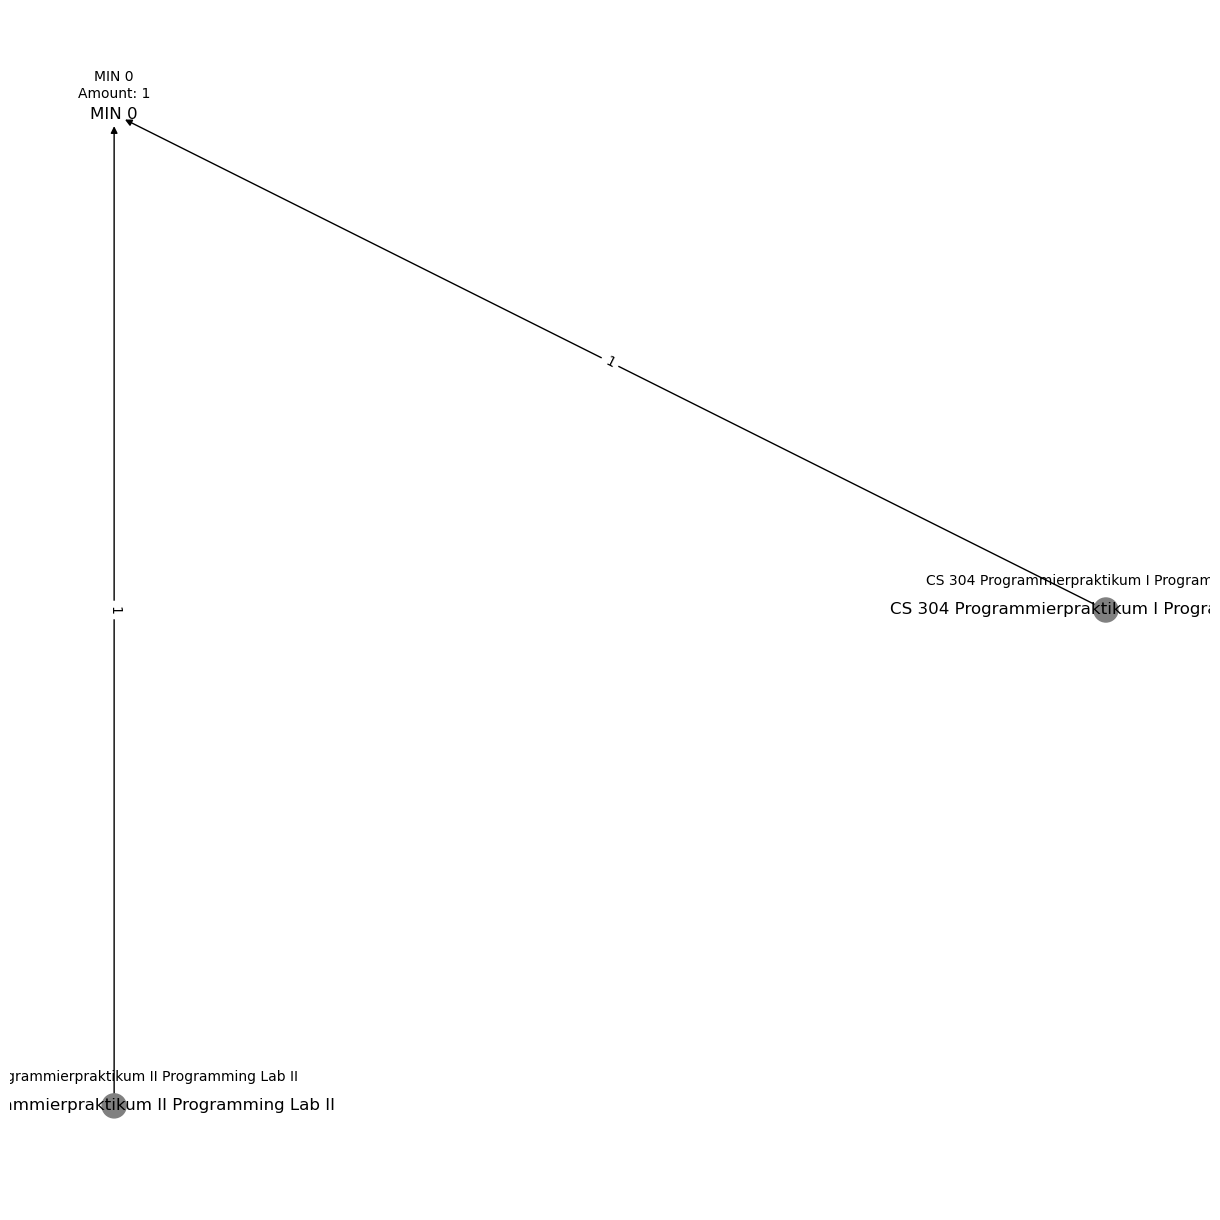

In [6]:
# Script for visualization

# Choose node
node_id = 'CS 306 Praktikum Software Engineering Software Engineering Practical'
node_id = 'MIN 0'
#node_id = 'CS 308 Softwaretechnik I Software Engineering I'

# Get relevant edges
incoming_nodes = [n for n in G.predecessors(node_id) if G.nodes[n].get("type") == "course" or G.nodes[n].get("type") == "prerequisite"]
#outgoing_nodes = [n for n in G.successors(node_id)]

# Combine relevant edges and create subgraph
#subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
subgraph_nodes = set([node_id] + incoming_nodes)

subgraph = G.subgraph(subgraph_nodes)

# Create layout for subgraph
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(12, 12))

# Draw subgraph
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)

# Add labels
node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}

nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)

edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)


plt.savefig("subgraph_with_edges.pdf", format="pdf")
plt.show()

## 3.2 Hubs & Bridges

In [7]:
# Calculate number of outgoing and ingoing skills

incoming_skills = []
outgoing_skills = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        count = 0
        weight = 0
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        incoming_skills.append([node, count, weight])
        
        outgoing_edges = G.out_edges(node)
        count = 0
        weight = 0
        for edge in outgoing_edges:
            if G.nodes[edge[1]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        outgoing_skills.append([node,count, weight])

In [8]:
# Get courses with the most highest number / weights for ingoing and outcoming skills

# Ingoing
incoming_skills_counts = [x[1] for x in incoming_skills]
incoming_skills_weights = [x[2] for x in incoming_skills]

incoming_skills_counts_avg = sum(incoming_skills_counts) / len(incoming_skills_counts)
incoming_skills_weights_avg = sum(incoming_skills_weights) / len(incoming_skills_counts)

incoming_skills_counts_sorted = sorted(incoming_skills, key=lambda x: x[1], reverse = True)
incoming_skills_weights_sorted = sorted(incoming_skills, key=lambda x: x[2], reverse = True)

# Outgoing
outgoing_skills_counts = [x[1] for x in outgoing_skills]
outgoing_skills_weights = [x[2] for x in outgoing_skills]

outgoing_skills_counts_avg = sum(outgoing_skills_counts) / len(outgoing_skills_counts)
outgoing_skills_weights_avg = sum(outgoing_skills_weights) / len(outgoing_skills_counts)

outgoing_skills_counts_sorted = sorted(outgoing_skills, key=lambda x: x[1], reverse = True)
outgoing_skills_weights_sorted = sorted(outgoing_skills, key=lambda x: x[2], reverse = True)

print(incoming_skills_counts_sorted[len(incoming_skills_counts_sorted)-1])


print("Average incoming skills number: " + str(incoming_skills_counts_avg))
print("Most incoming skills:")
for i in range(0, 10):
    print(incoming_skills_counts_sorted[i])

print("\nAverage outgoing skill number: " + str(outgoing_skills_counts_avg))
print("Most outgoing skills:")
for i in range(0, 10):
    print(outgoing_skills_counts_sorted[i])

print("\nAverage incoming skill weight: " + str(incoming_skills_weights_avg))
print("Highest incoming skill weights:")
for i in range(0, 10):
    print(incoming_skills_weights_sorted[i])

print("\nAverage outgoing skills: " + str(outgoing_skills_weights_avg))
print("Highest outgoing skill weights:")
for i in range(0, 10):
    print(outgoing_skills_weights_sorted[i])

['Grundlagen der Volkswirtschaftslehre', 0, 0]
Average incoming skills number: 5.611111111111111
Most incoming skills:
['SM 442 Bachelorseminar Prof. Stuckenschmidt Seminar', 17, 22.344750291425953]
['SM 443 Bachelorseminar Prof. Ponzetto Seminar', 17, 24.579609972963024]
['SM 444 Bachelorseminar Prof. Bizer Seminar', 17, 0.0]
['SM 445 Bachelorseminar Prof. Gemulla Seminar', 17, 24.287023484315352]
['SM 446 Bachelorseminar Prof. Moerkotte', 17, 21.543434155429164]
['SM 448 Bachelorseminar Prof. Krause Seminar', 17, 24.10131677851611]
['SM 449 Bachelorseminar Prof. Atkinson Seminar', 17, 22.869488972047513]
['SM 450 Bachelorseminar Prof. Armknecht Seminar', 17, 21.37433152291094]
['SM 451 Bachelorseminar Prof. Paulheim Seminar', 17, 0.0]
['SM 452 Bachelorseminar Prof. Heinzl Seminar', 17, 23.34424352203877]

Average outgoing skill number: 1.6666666666666667
Most outgoing skills:
['CS 305 Programmierpraktikum II Programming Lab II', 6, 3.676532893680275]
['IS 204 Wirtschaftsinformatik IV

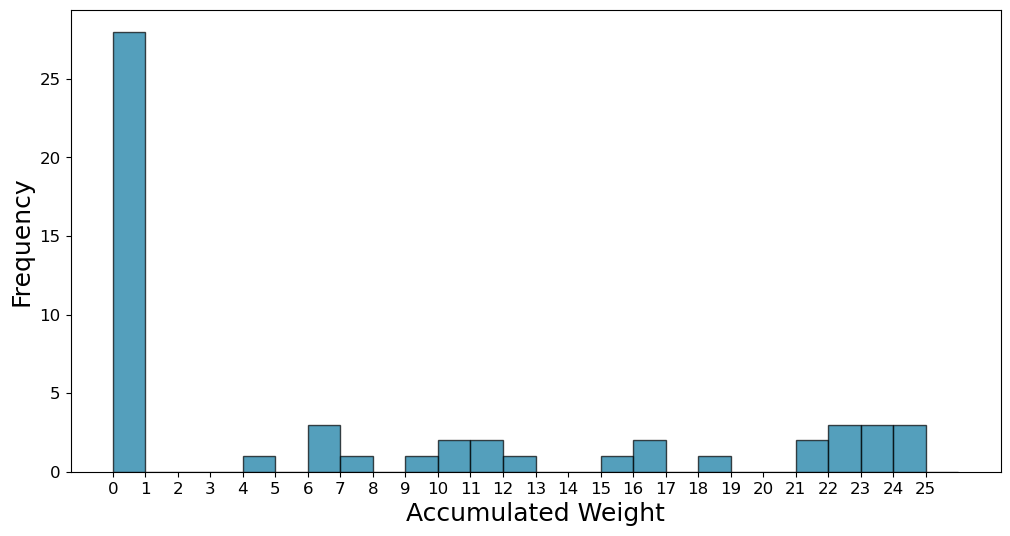

In [68]:
plt.figure(figsize=(12, 6))

bins = np.arange(min(incoming_skills_weights), max(incoming_skills_weights) + 2)
frequencies, bin_edges = np.histogram(incoming_skills_weights, bins=bins)

# Plot the bar chart
plt.bar(bin_edges[:-1], frequencies, width=1, align='edge', color='#0B76A0', edgecolor='black', alpha=0.7)

plt.xlabel('Accumulated Weight', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.xticks(np.arange(0,26))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('AccumulatedIncomingSkillWeights_Bachelor.png', format='png', dpi=300, bbox_inches='tight') 
plt.show()

In [10]:
node = "SM 443 Bachelorseminar Prof. Ponzetto Seminar"
incoming_edges = incoming_edges = G.in_edges(node)

for edge in incoming_edges:
    if G.nodes[edge[0]].get("type") == "skill":
        print(str(edge[0]) + ": " + str(G.edges[edge].get("weight")))



Software Development Fundamentals (SDF): 5.075110239585562
Algorithmic Foundations (AL): 2.989971975986662
Foundations of Programming Languages (FPL): 2.865391741451297
Software Engineering (SE): 1.970806080210793
Architecture and Organization (AR): 0.6392544378698227
Operating Systems (OS): 0.7843654774578497
Networking and Communication (NC): 0.9313487986407438
Parallel and Distributed Computing (PDC): 0.9313487986407438
Systems Fundamentals (SF): 1.305631217494111
Data Management (DM): 0.646161711115079
Security (SEC): 0.08582463928967811
Artificial Intelligence (AI): 1.858018716081591
Graphics and Interactive Techniques (GIT): 0.4725032142107474
Human-Computer Interaction (HCI): 0.1383918787373105
Mathematical and Statistical Foundations (MSF): 3.166078969368253
Information Systems (IS): 0.521225189581273
Business Process Management (BPM): 0.1981768872415094


In [11]:
# Script for visualization

# Choose node
node_id = 'SM 443 Bachelorseminar Prof. Ponzetto Seminar'
#node_id = 'CS 308 Softwaretechnik I Software Engineering I'

# Get relevant edges
incoming_nodes = [n for n in G.predecessors(node_id) if G.nodes[n].get("type") == "course" or G.nodes[n].get("type") == "skill"]
#outgoing_nodes = [n for n in G.successors(node_id)]

# Combine relevant edges and create subgraph
subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
#subgraph_nodes = set([node_id] + incoming_nodes)

subgraph = G.subgraph(subgraph_nodes)

# Create layout for subgraph
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(12, 12))

# Draw subgraph
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)

# Add labels
node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}

nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)

edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)


plt.savefig("subgraph_with_edges.pdf", format="pdf")
plt.show()

NameError: name 'outgoing_nodes' is not defined

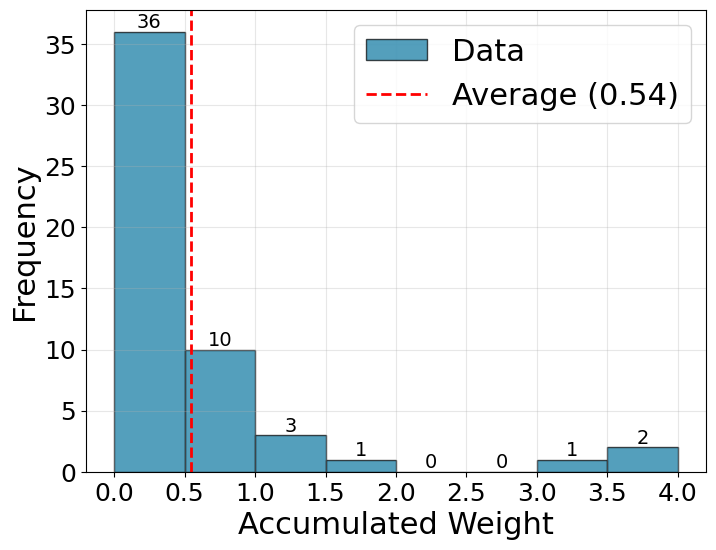

In [38]:
# Create Histogramms
plt.figure(figsize=(8, 6))
bins = np.linspace(0, 4, 9)
counts, bin_edges, bars = plt.hist(outgoing_skills_weights, bins=bins, color='#0B76A0', edgecolor='black', alpha=0.7, label='Data')

# Add Counts above bars
for count, edge in zip(counts, bin_edges[:-1]):
    plt.text(edge + (bin_edges[1] - bin_edges[0]) / 2, count + 0.3, f'{int(count)}', ha='center', fontsize=14)

# Add average
plt.axvline(outgoing_skills_weights_avg, color='red', linestyle='dashed', linewidth=2, label=f'Average ({outgoing_skills_weights_avg:.2f})')

# Add Labels
plt.xlabel('Accumulated Weight', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.legend(fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)

# Show and export
plt.savefig('HistogramAccumulatedOutgoingEdges_Bachelor.png', format='png', dpi=300, bbox_inches='tight') 
plt.show()